## A pedagogical implementation of the simplex method
This is a simple implementation of the simplex method that can be vastly improved with 
better use of data structures and design. This code is designed to be used for
classroom exercises and makes no attempt to be efficient at all.

The overall organization of the code is that we have:
* `SimplexState` which represents the current vertex and problem
* `SimplexPoint` which represents the KKT information at a point

We can create a `SimplexPoint` from a `SimplexState` to understand
the current point.

Then the fundamental iteration is `simplex_step`, which moves
from one vertex to another and returns an updated `SimplexState`

## Our running example
We'll use this example to illustrate the codes

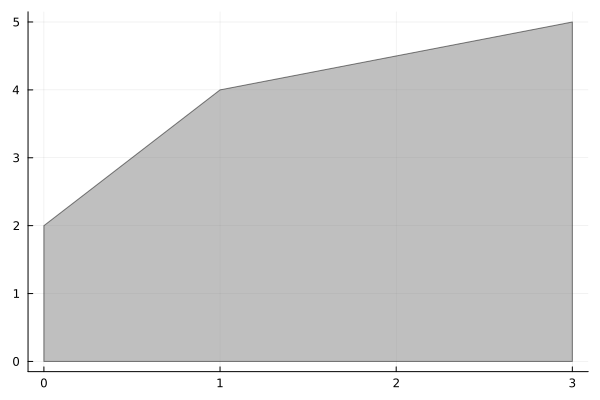

In [1]:
using LinearAlgebra
A1 = [-2.0 1; 
      -1 2; 
       1 0]
b = [2.0; 7; 3]

A = [A1 Matrix{Float64}(I,3,3)] # form the problem with slacks.

include("plotregion.jl")
PlotRegion.plotregion(A,b)

### Types

In [2]:
struct SimplexState
    c::Vector    
    A::Matrix
    b::Vector
    bset::Vector{Int} # columns of the BFP
end

In [8]:
struct SimplexPoint
    x::Vector   # 
    binds::Vector{Int}
    ninds::Vector{Int}
    lam::Vector # equality Lagrange mults
    sn::Vector  # non-basis Lagrange mults
    B::Matrix   # the set of basic cols
    N::Matrix   # the set of non-basic cols
end

# These are constructors for 
function SimplexPoint(T::Type)
    return SimplexPoint(zeros(T,0),zeros(Int,0),zeros(Int,0),
        zeros(T,0), zeros(T,0), zeros(T,0), zeros(T,0))
end

function SimplexPoint(T::Type, B::Matrix, N::Matrix)
    return SimplexPoint(zeros(T,0),zeros(Int,0),zeros(Int,0),
        zeros(T,0), zeros(T,0), B, N)
end

function simplex_point(state::SimplexState)
    m,n = size(state.A)
    @assert length(state.bset) == m "need more indices to define a BFP"
    binds = state.bset # basic variable indices
    ninds = setdiff(1:size(A,2),binds) # non-basic
    B = state.A[:,binds]
    N = state.A[:,ninds]
    cb = state.c[binds]
    cn = state.c[ninds]
    c = state.c
    
    @show cn
    
    if rank(B) != m
        return (:Infeasible, SimplexPoint(eltype(c), B, N))
    end
    
    xb = B\b
    x = zeros(eltype(xb),n)
    x[binds] = xb
    x[ninds] = zeros(eltype(xb),length(ninds))
    
    lam = B'\cb
    sn = cn - N'*lam
    
    @show sn
    
    if any(xb .< 0)
        return (:Infeasible, SimplexPoint(x, binds, ninds, lam, sn, B, N))
    else
        if all(sn .>= 0)
            return (:Solution, SimplexPoint(x, binds, ninds, lam, sn, B, N))
        else
            return (:Feasible, SimplexPoint(x, binds, ninds, lam, sn, B, N))
        end
    end
end

A1 = [-2.0 1; 
      -1 2; 
       1 0]
b = [2.0; 7; 3]

A = [A1 Matrix{Float64}(I,3,3)] # form the problem with slacks.

state = SimplexState([-1.0,-2.0,0.0,0.0,0.0],A,b,[1,2,3])
status,pt = simplex_point(state)
@show status
@show pt.sn
@show pt.x


cn = [0.0, 0.0]
sn = [1.0, 2.0]
status = :Solution
pt.sn = [1.0, 2.0]
pt.x = [3.0, 5.0, 3.0, 0.0, 0.0]


5-element Vector{Float64}:
 3.0
 5.0
 3.0
 0.0
 0.0

### Phase 1: Crash or Presolve
We need to find an initial basis. We'll see how to do this soon.

In [ ]:
function simplex_init(c,A,b)
end

In [9]:
function simplex_step!(state::SimplexState)
    # get the current point from the new basis
    stat,p::SimplexPoint = simplex_point(state)
    
    if stat == :Solution
        return stat, p
    elseif state == :Infeasible
        return :Breakdown, p
    else # we have a BFP
        #= This is the Simplex Step! =#
        
        # take the Dantzig index to add to basic
        qn = findmin(p.sn)[2]
        q = p.ninds[qn] # translate index
        # check that nothing went wrong
        @assert all(state.A[:,q] == p.N[:,qn]) 
        
        d = p.B \ state.A[:,q] 
        #@show d
        
        # TODO, implement an anti-cycling method /         
        # check for stagnation and lack of progress
        # this checks for unbounded solutions
        if all(d .<= eps(eltype(d)))
            return :Degenerate, p
        end
    
        # determine the index to remove
        xq = p.x[p.binds]./d
        ninds = d .< eps(eltype(xq))
        xq[d .< eps(eltype(xq))] .= Inf
        pb = findmin(xq)[2]
        pind = p.binds[pb] # translate index 
        
        #@show p.binds, pb, pind, state.bset, q
        
        # remove p and add q
        @assert state.bset[pb] == pind
        state.bset[pb] = q
        
        return stat, p
    end
end

A1 = [-2.0 1; 
      -1 2; 
       1 0]
b = [2.0; 7; 3]

A = [A1 Matrix{Float64}(I,3,3)] # form the problem with slacks.

state = SimplexState([-1.0,-2.0,0.0,0.0,0.0],A,b,[2,4,5])
@show state.bset
status, p = simplex_step!(state)
@show state.bset, status

state.bset = [2, 4, 5]
cn = [-1.0, 0.0]
sn = [-5.0, 2.0]
(state.bset, status) = ([2, 1, 5], :Feasible)


([2, 1, 5], :Feasible)

In [12]:
state = SimplexState([-1.0,-2.0,0.0,0.0,0.0],A,b,[2,1,3])
status, p = simplex_step!(state)
@show state.bset, status

cn = [0.0, 0.0]
sn = [1.0, 2.0]
(state.bset, status) = ([2, 1, 3], :Solution)


([2, 1, 3], :Solution)

## The simplex method on our example

state.bset = [3, 4, 5]


cn = [-1.0, -2.0]
sn = [-1.0, -2.0]
state.bset = [2, 4, 5]
cn = [-1.0, 0.0]
sn = [-5.0, 2.0]
state.bset = [2, 1, 5]
cn = [0.0, 0.0]
sn = [-1.3333333333333335, 1.6666666666666667]
state.bset = [2, 1, 3]
cn = [0.0, 0.0]
sn = [1.0, 2.0]


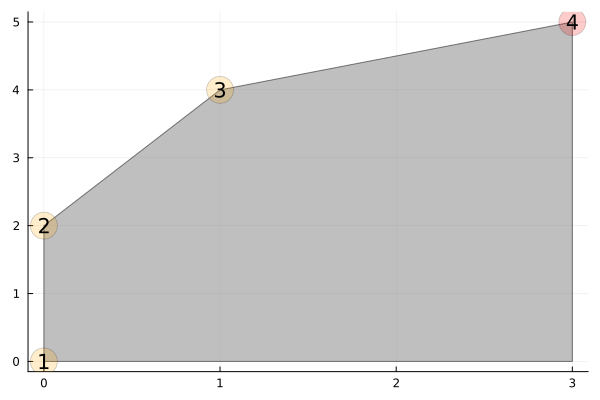

In [13]:
using Plots
A1 = [-2.0 1; 
      -1 2; 
       1 0]
b = [2.0; 7; 3]

A = [A1 Matrix{Float64}(I,3,3)] # form the problem with slacks.

include("plotregion.jl")
PlotRegion.plotregion(A,b)

# start off with the point (0,0)
state = SimplexState([-1.0,-2.0,0.0,0.0,0.0],A,b,
    [3,4,5])
@show state.bset
status, p = simplex_step!(state)
iter = 1
while status != :Solution
    @show state.bset
    scatter!([p.x[1]],[p.x[2]],
        series_annotations=["$(iter)"],marker=(15,0.2,:orange),label="")
    status, p = simplex_step!(state)
    iter += 1
end
scatter!([p.x[1]],[p.x[2]],
    series_annotations=["$(iter)"],marker=(15,0.2,:red),label="")